# 회고
### 상관계수
- corrwith 와같은 함수로 상관계수를 구할 수 있다,
- 상관계수가 적은 것을 제외하면 결과가 좋아지지 않을까 생각을 했었다
- 하지만 다른 사람의 의견을 들어보고 우수 노트북들을 보니 아닌 것 같다

### 실험
- 결국 실험을 많이 해야하는 것 같다.
- 결과에 영향을 주는 요소들을 정리하고 체계적인 실험을 통해 좋은 성적을 내보자

### 이상치 제거
- data들을 scatter로 출력해보는데 어떤 이상치를 제거해야하는 지 잘 모르겠다

In [47]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

LMS 클라우드 서버 내 나의 폴더 지정

In [49]:
PATH = "/aiffel/aiffel/aiffel/explorations/06_kaggle/data"

In [50]:
train_data_path = join(PATH, 'train.csv')
test_data_path = join(PATH, 'test.csv')

print(train_data_path, test_data_path)

/aiffel/aiffel/aiffel/explorations/06_kaggle/data/train.csv /aiffel/aiffel/aiffel/explorations/06_kaggle/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [51]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [52]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [53]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## corrwith 함수로 상관계수 구하기
pearson

In [54]:
train.corrwith(train['price']).sort_values()

zipcode         -0.051498
date             0.007717
id               0.020899
long             0.023547
condition        0.039740
yr_built         0.047290
sqft_lot15       0.086384
sqft_lot         0.096793
yr_renovated     0.140808
floors           0.262588
waterfront       0.265738
lat              0.301604
sqft_basement    0.322218
bedrooms         0.323672
view             0.400806
bathrooms        0.525479
sqft_living15    0.586419
sqft_above       0.608577
grade            0.667211
sqft_living      0.702899
price            1.000000
dtype: float64

kendall

In [55]:
train.corrwith(train['price'], method='kendall').sort_values()

zipcode         -0.010303
date            -0.001219
condition        0.016905
id               0.024601
sqft_lot15       0.040103
long             0.045224
sqft_lot         0.050527
yr_built         0.067704
yr_renovated     0.090879
waterfront       0.092508
sqft_basement    0.185629
view             0.235770
floors           0.256619
bedrooms         0.269782
lat              0.288923
bathrooms        0.370594
sqft_above       0.382732
sqft_living15    0.406098
sqft_living      0.465533
grade            0.531341
price            1.000000
dtype: float64

spearman

In [56]:
train.corrwith(train['price'], method='spearman').sort_values()

zipcode         -0.009266
date            -0.001679
condition        0.021520
id               0.036892
sqft_lot15       0.065771
long             0.071757
sqft_lot         0.080554
yr_built         0.097844
yr_renovated     0.112381
waterfront       0.113179
sqft_basement    0.245304
view             0.291720
floors           0.328674
bedrooms         0.350185
lat              0.450692
bathrooms        0.498989
sqft_above       0.547868
sqft_living15    0.573777
sqft_living      0.646482
grade            0.662125
price            1.000000
dtype: float64

scatter 출력

In [57]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

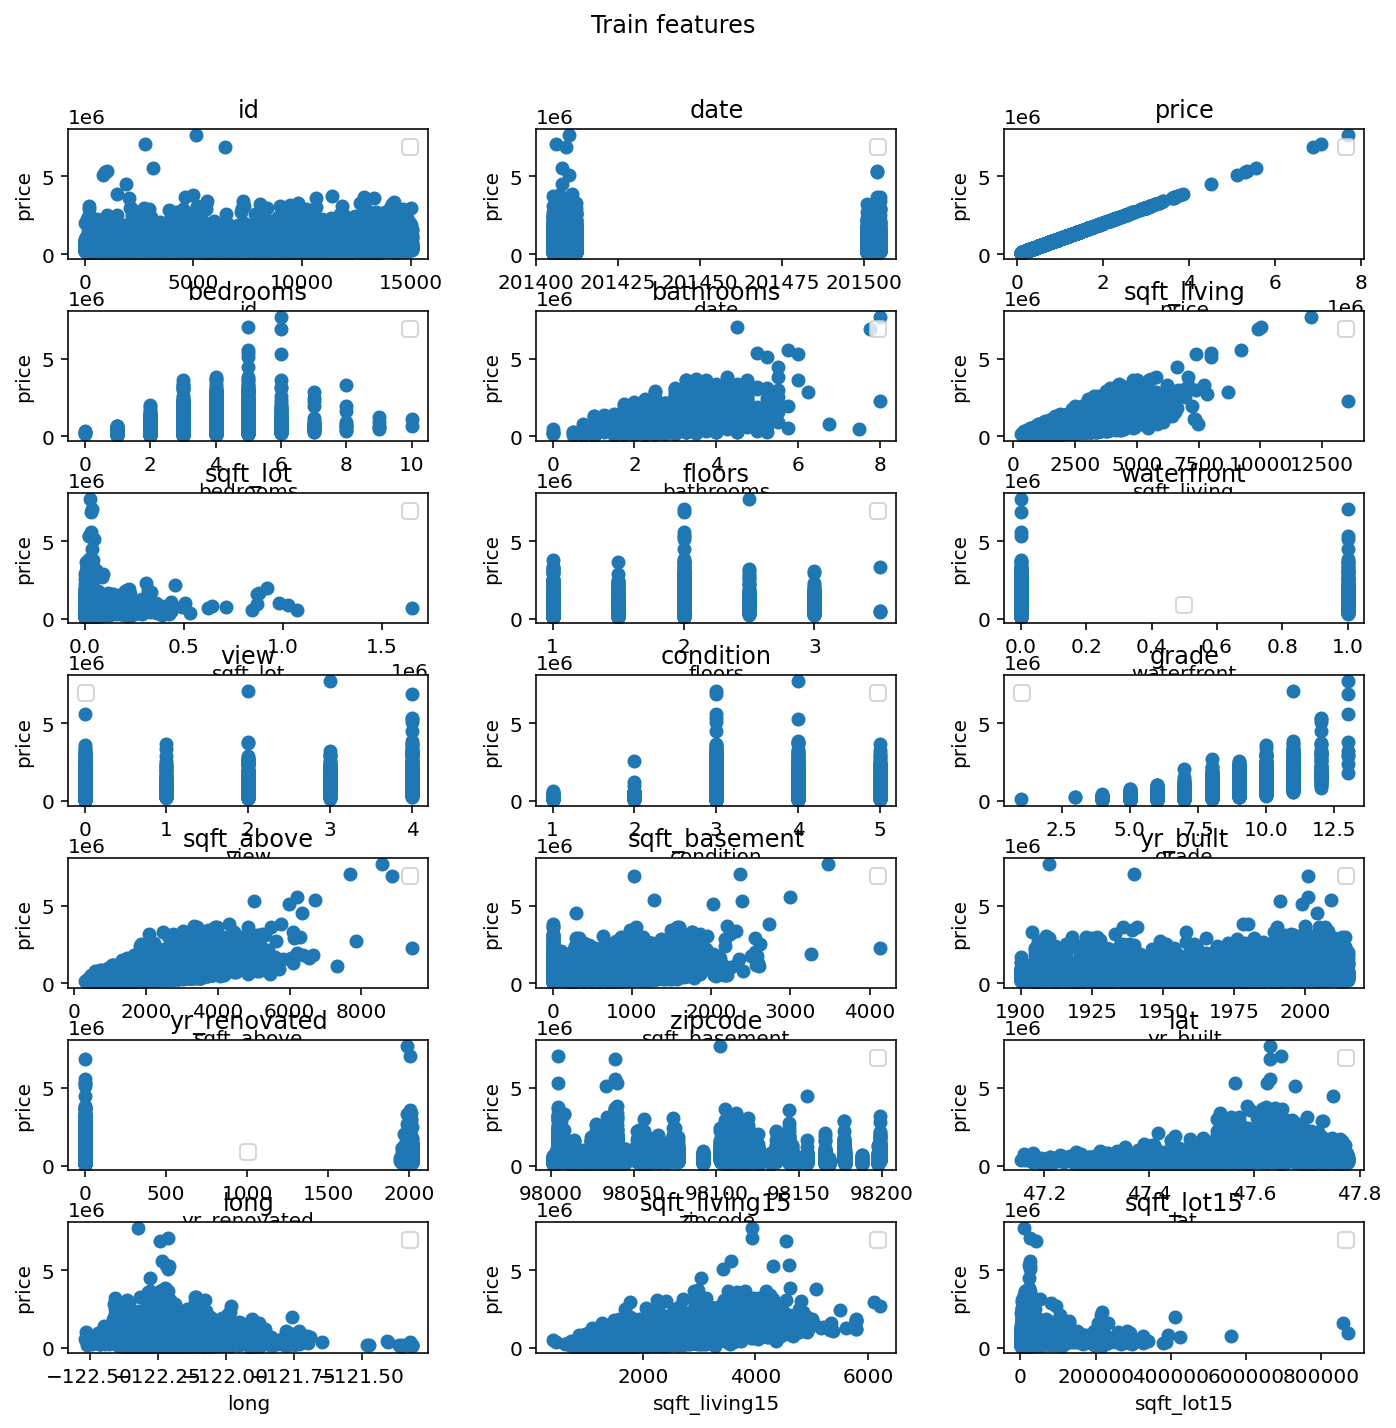

In [58]:
fig, ax = plt.subplots(7, 3, figsize=(10,10))

for idx, col in enumerate(train.columns):
    i = idx // 3
    j = idx % 3
    ax[i, j].scatter(train[col], train.price)
    ax[i, j].set_xlabel(col)
    ax[i, j].set_ylabel('price')
    ax[i, j].set_title(col)
    ax[i, j].legend(col, 'price')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
plt.suptitle('Train features')
plt.show()

이상치 제거

In [60]:
train[train.sqft_living > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,2280000.0,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [94]:
train.drop(8912, axis=0, inplace=True)
train[train.sqft_living > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [95]:
train[(train.grade == 11) & (train.price > 5000000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,7062500.0,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [96]:
train.drop(2775, axis=0, inplace=True)
train[(train.grade == 11) & (train.price > 5000000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


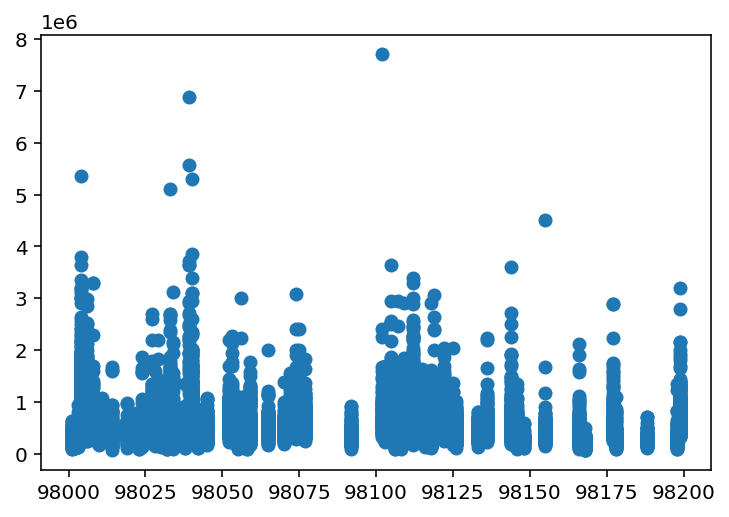

In [97]:
plt.scatter(train.zipcode, train.price)

In [106]:
train[train.price > 7000000]['zipcode']

5108    98102
Name: zipcode, dtype: int64

In [107]:
train[train['zipcode'] == 98102].sort_values(by=['price'])

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12076,12076,201406,330000.0,3,2.50,1070,1155,2.0,0,0,...,7,720,350,2005,0,98102,47.5617,-122.385,1120,2594
5807,5807,201501,350000.0,2,1.00,1070,2880,1.0,0,0,...,7,1070,0,1902,0,98102,47.6261,-122.324,2030,2880
2434,2434,201409,390000.0,2,1.75,1150,2723,1.0,0,0,...,7,770,380,1923,0,98102,47.6357,-122.322,1440,4000
15015,15015,201406,399950.0,2,1.00,710,1157,2.0,0,0,...,7,710,0,1943,0,98102,47.6413,-122.329,1370,1173
13977,13977,201406,399950.0,2,1.00,710,1131,2.0,0,0,...,7,710,0,1943,0,98102,47.6413,-122.329,1370,1173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363,11363,201407,1600000.0,3,2.25,3170,5000,2.0,0,0,...,10,2230,940,1975,0,98102,47.6349,-122.318,3170,5400
2385,2385,201411,1675000.0,6,2.25,4910,6600,2.5,0,0,...,10,3580,1330,1910,0,98102,47.6458,-122.320,3280,5500
13737,13737,201408,2250000.0,3,3.25,3890,3452,2.0,0,0,...,12,2890,1000,2006,0,98102,47.6260,-122.323,2860,2199
1403,1403,201411,2400000.0,4,3.75,4090,24825,2.0,0,0,...,11,3400,690,1926,0,98102,47.6338,-122.319,3910,11500


In [71]:
train['zipcode'].values

15035

In [80]:
train[train['zipcode'] == 98115]['price'].median()

570000.0

In [82]:
zip_dict = {}
for val in train['zipcode'].values:
    zip_dict[val] = train[train['zipcode'] == val]['price'].median()

zip_dict

{98178: 273500.0,
 98028: 438000.0,
 98074: 645000.0,
 98003: 265000.0,
 98198: 269875.0,
 98007: 580000.0,
 98115: 570000.0,
 98107: 529475.0,
 98126: 399950.0,
 98019: 410000.0,
 98103: 549000.0,
 98002: 235000.0,
 98133: 370000.0,
 98040: 998000.0,
 98030: 289475.0,
 98119: 779000.0,
 98112: 950000.0,
 98027: 575000.0,
 98117: 535000.0,
 98058: 335500.0,
 98001: 255000.0,
 98056: 383000.0,
 98166: 389999.5,
 98053: 633650.0,
 98023: 269950.0,
 98105: 679500.0,
 98042: 290000.0,
 98008: 546800.0,
 98148: 267500.0,
 98122: 570000.0,
 98004: 1150000.0,
 98005: 772000.0,
 98034: 445000.0,
 98125: 426500.0,
 98075: 734000.0,
 98010: 390000.0,
 98038: 342000.0,
 98059: 437500.0,
 98092: 322750.0,
 98136: 514000.0,
 98199: 689800.0,
 98032: 250000.0,
 98045: 427000.0,
 98102: 720000.0,
 98077: 660000.0,
 98108: 344475.0,
 98168: 235000.0,
 98177: 552250.0,
 98118: 375000.0,
 98006: 756000.0,
 98146: 305000.0,
 98033: 675000.0,
 98052: 611000.0,
 98155: 367500.0,
 98024: 451000.0,
 98116: 5

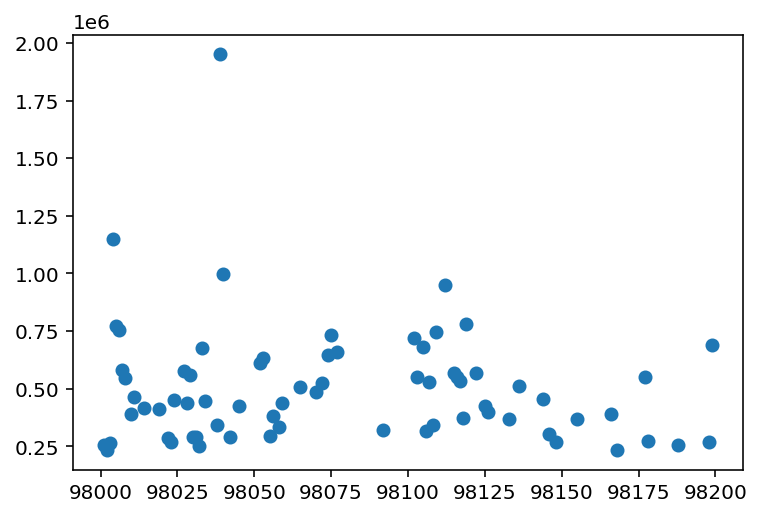

In [84]:
plt.scatter(zip_dict.keys(), zip_dict.values())

zipcode도 활용을 하면 도움이 되겠구나
어떻게 활용을해서 EDA를 할까?

In [108]:
y = train['price']
del train['price']
del train['id']

In [109]:
train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [110]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

In [111]:
test.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [112]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15034, dtype: float64

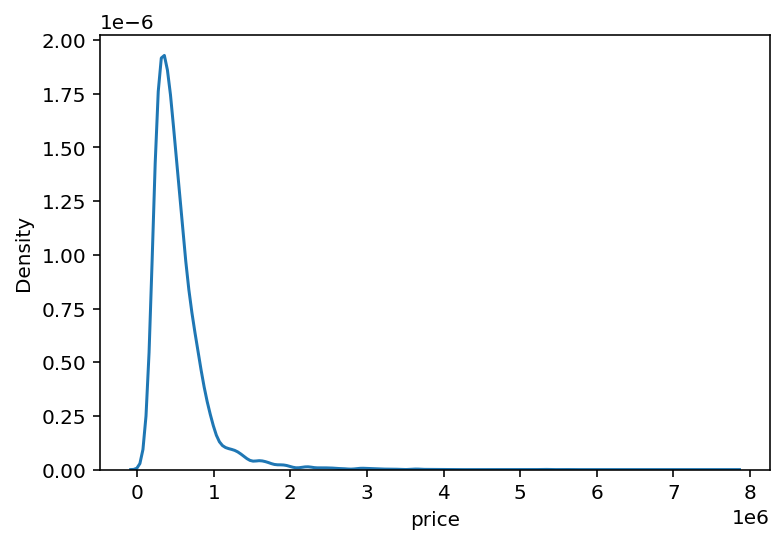

In [113]:
sns.kdeplot(y)
plt.show()

In [114]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15034, dtype: float64

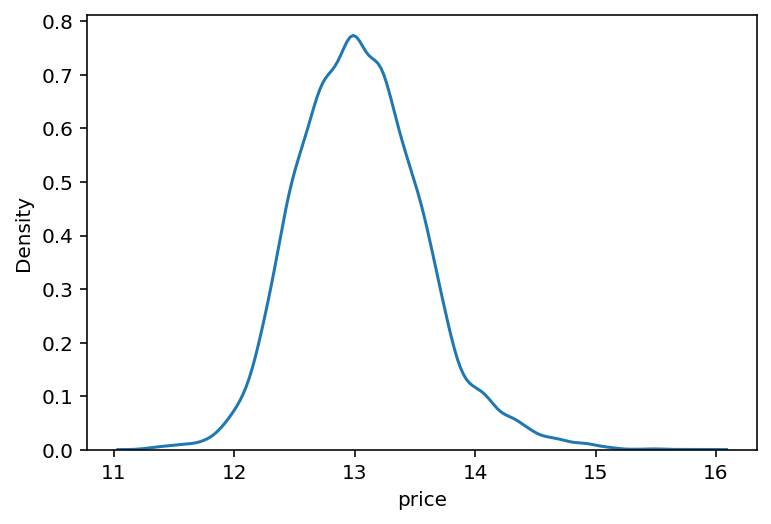

In [115]:
sns.kdeplot(y)
plt.show()

In [116]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15034 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15034 non-null  int64  
 1   bedrooms       15034 non-null  int64  
 2   bathrooms      15034 non-null  float64
 3   sqft_living    15034 non-null  int64  
 4   sqft_lot       15034 non-null  int64  
 5   floors         15034 non-null  float64
 6   waterfront     15034 non-null  int64  
 7   view           15034 non-null  int64  
 8   condition      15034 non-null  int64  
 9   grade          15034 non-null  int64  
 10  sqft_above     15034 non-null  int64  
 11  sqft_basement  15034 non-null  int64  
 12  yr_built       15034 non-null  int64  
 13  yr_renovated   15034 non-null  int64  
 14  zipcode        15034 non-null  int64  
 15  lat            15034 non-null  float64
 16  long           15034 non-null  float64
 17  sqft_living15  15034 non-null  int64  
 18  sqft_l

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [118]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [119]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [120]:
xgboost = XGBRegressor(random_state=42)

In [121]:
for k, v in params.items():
    if k not in init_params or (
            repr(v) != repr(init_params[k])
            and not (is_scalar_nan(init_params[k]) and is_scalar_nan(v))):
        filtered_params[k] = v

NameError: name 'params' is not defined

In [ ]:
xgboost

In [122]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다.
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [123]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [124]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [125]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,162316.787726
RandomForestRegressor,151048.554934
LGBMRegressor,142361.780438
XGBRegressor,136920.436316


In [126]:
from sklearn.model_selection import GridSearchCV

In [127]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [128]:
models[3]

RandomForestRegressor(random_state=2020)

In [136]:
param_grid = {
    'max_depth': [1, 10, -1],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'n_estimators': [50, 60, 70, 80, 90, 100],
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  52 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 182 tasks      | elapsed:   23.9s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:   47.0s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,score,RMSLE
65,0.1000,10,100,-0.026955,0.164179
71,0.1000,-1,100,-0.026980,0.164255
70,0.1000,-1,90,-0.027154,0.164784
64,0.1000,10,90,-0.027173,0.164842
69,0.1000,-1,80,-0.027422,0.165596
...,...,...,...,...,...
4,0.0001,1,90,-0.276463,0.525797
3,0.0001,1,80,-0.276645,0.525970
2,0.0001,1,70,-0.276827,0.526144
1,0.0001,1,60,-0.277010,0.526317


In [131]:
model = LGBMRegressor(max_depth=10, n_estimators=100, learning_rate=0.1, random_state=random_state)

In [132]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = join(PATH, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = './submission_{}_RMSLE_{}.csv'.format(model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [133]:
PATH

'/aiffel/aiffel/aiffel/explorations/06_kaggle/data'

In [135]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.01634')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
./submission_lgbm_RMSLE_0.01634.csv saved!
